In [2]:
import pyGM as gm
import pyGM.montecarlo
import numpy as np
import matplotlib.pyplot as plt

# Likelihood Weighting

Using the alarm file, estimate the posterior probability P(X2=0|X5=0,X23=0,X25=0,X30=0)

In [12]:
def likelihood_sample(do_print = False, do_ev = False, plotting = False):
    factors = gm.readUai('alarm.uai')
    model = gm.GraphModel(factors)
    X = model.X
    evidence = {X[5]:0, X[23]:0, X[25]:0, X[30]:0}
    order = gm.bnOrder(model)
    U, D, W = np.zeros((10000,37), dtype=int), np.zeros((10000,37), dtype=int), np.zeros((10000,))
    print_stage = 1
    result = None
    results = []
    for s in range(8193):
        Qs, D[s,:] = gm.bnSample(model, order, evidence)
        W[s] = np.exp( model.logValue(D[s,:]) - Qs )
        probM = (W/W.sum()).dot( D )
        U[s] = (D[s,:]==0).sum()
        if s == print_stage and do_print and do_ev:
            print("m = {:>5}: {}".format(print_stage, U[s][0]))
            print_stage *= 2
            results.append(U[s][0])
        elif s == print_stage and do_print:
            print("m = {:>5}: {}".format(print_stage, 1-probM[2]))
            print_stage *= 2
        elif s == print_stage and do_ev and plotting:
            results.append(U[s][0])
            print_stage *= 2
        elif s == print_stage and plotting:
            results.append(1-probM[2])
            print_stage *= 2
            
        if s == 8192 and do_ev:
            result = U[s][0]
            #results.append(result)
        elif s == 8192:
            result = 1-probM[2]
            #results.append(result)
            
    if plotting:
        return results
    
    return result

In [4]:
likelihood_sample(True)

m =     1: 0.0
m =     2: 0.0
m =     4: 0.0
m =     8: 0.8620226787334152
m =    16: 0.5106120847420794
m =    32: 0.42898103113914854
m =    64: 0.5791931211102976
m =   128: 0.5075847997585389
m =   256: 0.5447015721137025
m =   512: 0.6177758089095398
m =  1024: 0.6640699276458601
m =  2048: 0.6573751967585806
m =  4096: 0.6415483513740637
m =  8192: 0.6490607747549426


0.6490607747549426

Running this multiple times, we can see that the value converges around the value 0.6

In [5]:
r = []
for i in range(5):
    r.append(likelihood_sample(plotting = True))

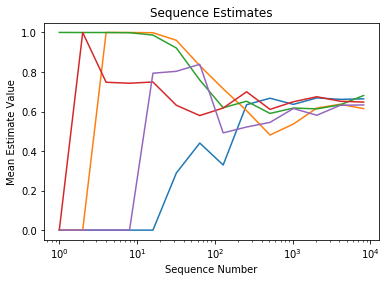

In [6]:
xtick = [2**x for x in range(14)]

for _r in r:
    plt.semilogx(xtick, _r)
plt.title("Sequence Estimates")
plt.xlabel("Sequence Number")
plt.ylabel("Mean Estimate Value")
plt.show()

# Gibbs Sampling

Repeat the same process as before, but using Gibbs Sampling to determine the posterior probability.

In [16]:
def gibbs_sample(do_print = False, do_ev = False, plotting = False):
    factors = gm.readUai('alarm.uai')
    model = gm.GraphModel(factors)
    X = model.X
    evidence = {X[5]:0, X[23]:0, X[25]:0, X[30]:0}
    model.condition(evidence)
    print_stage = 1
    result = None
    results = []
    for s in range(8193):
        if s == print_stage:
            Q = gm.montecarlo.QueryMarginals( gm.Factor([Xi], 0.0) for Xi in X )
            Q = gm.montecarlo.GibbsSampling(model, Q, stopSamples=s)
            if not do_ev:
                result = Q[2][0]
            else:
                n = 0
                for f in Q:
                    if 0.0 in list(f.table):
                        n+= 1
                result = n
                
            if do_print:
                print("m = {:>5}: {}".format(s, result))
            print_stage *= 2
            results.append(result)
    if plotting:
        return results
    return result

In [21]:
gibbs_sample(True) 

m =     1: 0.0
m =     2: 0.0
m =     4: 1.0
m =     8: 1.0
m =    16: 0.5
m =    32: 0.71875
m =    64: 0.75
m =   128: 0.625
m =   256: 0.63671875
m =   512: 0.615234375
m =  1024: 0.65625
m =  2048: 0.658203125
m =  4096: 0.59912109375
m =  8192: 0.63232421875


0.63232421875

In [22]:
r = []
for i in range(5):
    print(i)
    while True:
        try:
            r.append(gibbs_sample(plotting = True))
            break
        except AssertionError: #Handle log-zero issues
            continue

0
1
2
3
4


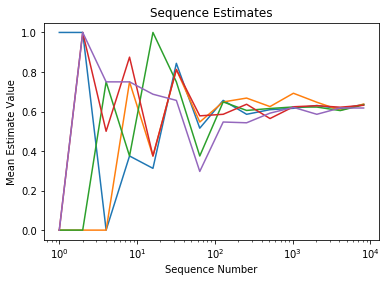

In [23]:
for _r in r:
    plt.semilogx(xtick, _r)
plt.title("Sequence Estimates")
plt.xlabel("Sequence Number")
plt.ylabel("Mean Estimate Value")
plt.show()

We can see that these results are very similar to the results of Likelihood Weighting, but converges much more quickly to a more consistent value.